In [1]:
import numpy as np
import skimage as sk
from skimage import morphology as skm
import cv2
import os
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [2]:
#FIXME setup the folder location
TRAIN_FOLDER = "Data/TRAIN/"
EX_FOLDER = "Data/"

In [3]:
ex_imgs = [EX_FOLDER + path for path in os.listdir(EX_FOLDER) if path[:2] == "ex" and path[-3:] == "jpg"]
ex_imgs.sort()

In [4]:
ex_csv = [EX_FOLDER + path for path in os.listdir(EX_FOLDER) if path[:2] == "ex" and path[-3:] == "csv"]
ex_csv.sort()

In [5]:
train_imgs = [TRAIN_FOLDER + path for path in os.listdir(TRAIN_FOLDER) if path[-3:] == "jpg"]
train_imgs.sort()

In [6]:
def plot_images(path_lst, csv=None, max=6):
    plt.figure(figsize=(20,15))
    for i, path in enumerate(path_lst):
        if i == max:
            break
        plt.subplot(max//2, 2, i+1)
        if csv:
            for point in np.genfromtxt(csv[i],delimiter=','):
                plt.plot(point[1], point[0], marker='x', color="red")
        im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2LAB)
        im,_,_ = cv2.split(im)
        #im = im - cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        #im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        plt.imshow(im, cmap="gray")
        
    plt.show()

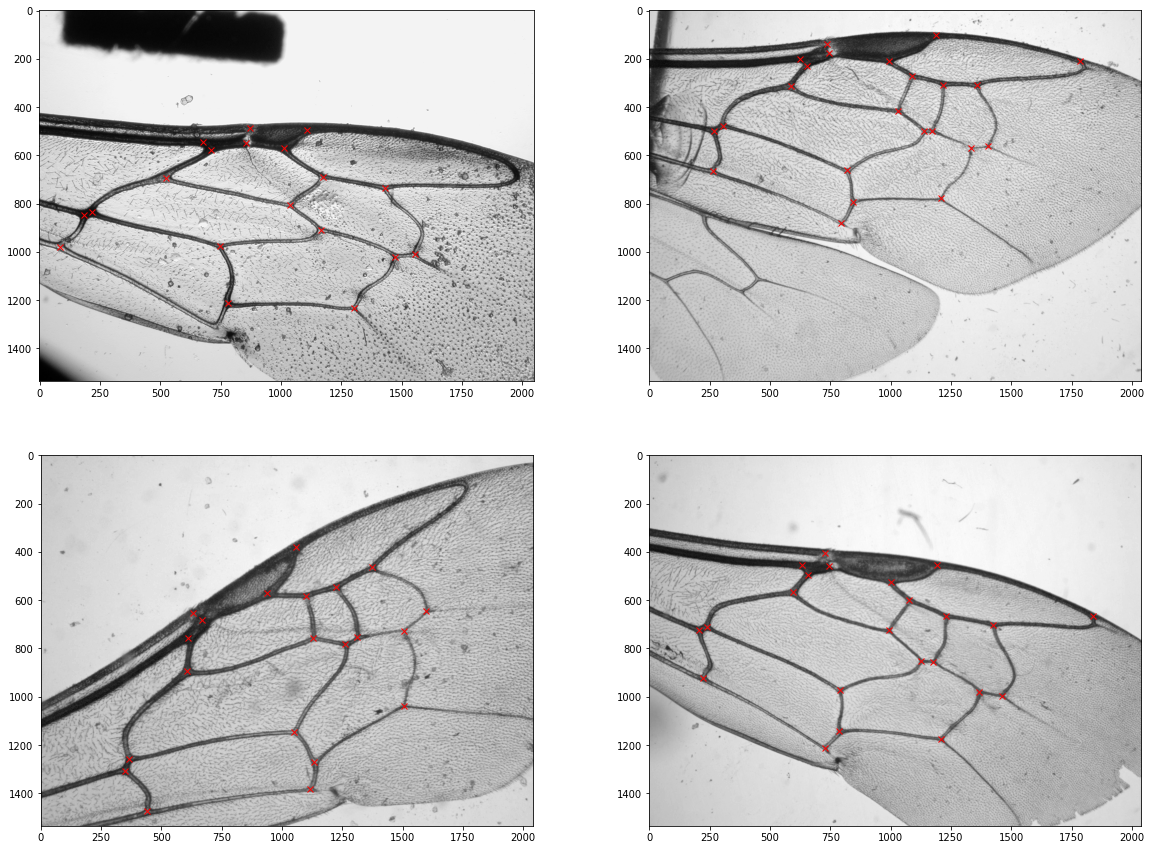

In [7]:
plot_images(ex_imgs,csv=ex_csv, max=4)

# Blood vessel segmentation
## Pre-processing

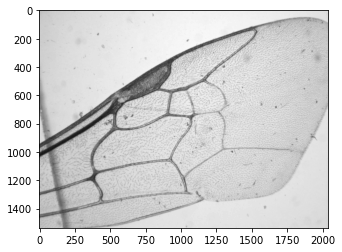

In [35]:
im = cv2.cvtColor(cv2.imread(train_imgs[15]), cv2.COLOR_BGR2LAB)
im,_,_ = cv2.split(im)
plt.imshow(im, cmap="gray")

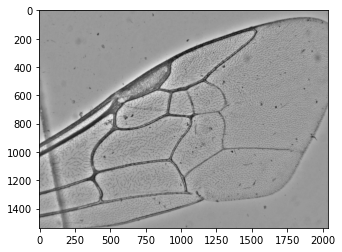

In [52]:
im_diff_gaussians = ((sk.filters.difference_of_gaussians(im, 0, 35) + 1) * 256 / 2).astype(np.uint8)
plt.imshow(im_diff_gaussians, cmap="gray")

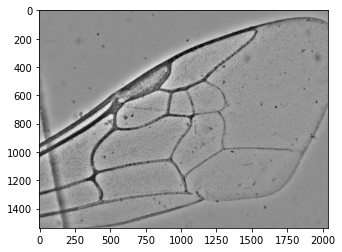

In [53]:
im_open = skm.closing(im_diff_gaussians, skm.disk(3))
plt.imshow(im_open, cmap="gray")

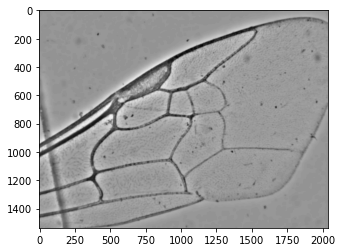

In [54]:
im_gaussian = gaussian_filter(im_open, sigma=2)
plt.imshow(im_gaussian, cmap="gray")

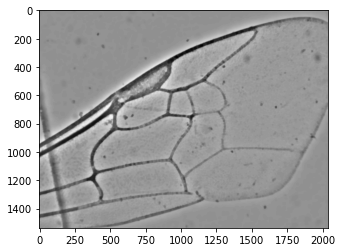

In [55]:
im_dilate = skm.closing(im_gaussian, skm.disk(5))
plt.imshow(im_dilate, cmap="gray")

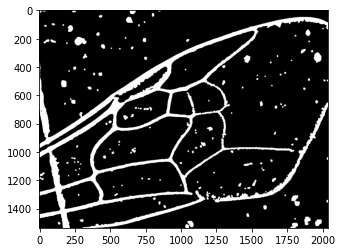

In [56]:
im_treshold = im_dilate < 127
plt.imshow(im_treshold, cmap="gray")

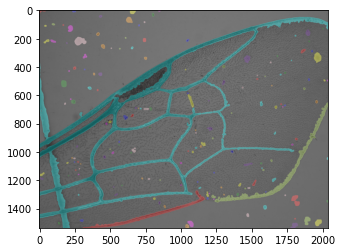

In [57]:
im_label = sk.measure.label(im_treshold)
im_label_overlay = sk.color.label2rgb(im_label, image=im, bg_label=0)
plt.imshow(im_label_overlay)

In [58]:
tmp = np.where(np.bincount(im_label.flatten()) > 30000)[0][1:]
im_filter = np.zeros_like(im_label).astype(bool)
for value in tmp:
    im_filter = im_filter | (im_label == value)

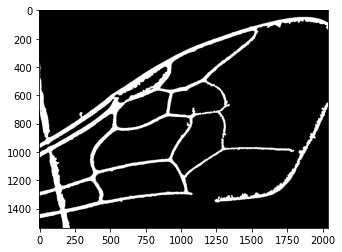

In [59]:
plt.imshow(im_filter, cmap="gray")

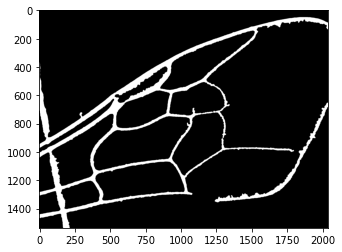

In [60]:
res = gaussian_filter(skm.binary_closing(im_filter, skm.disk(4)), sigma=0.2)
plt.imshow(res, cmap="gray")

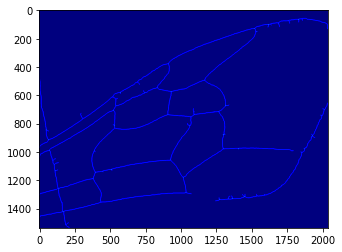

In [61]:
skeleton = skm.skeletonize(res)
plt.imshow(skeleton, cmap="jet")

In [62]:
def my_subtract(a,b):
    res = np.copy(a)
    if a.shape[0] % 2 == 0 or a.shape[1] != a.shape[0] or b.shape[0] % 2 == 0 or b.shape[1] != b.shape[0]:
        return
    dif = abs(a.shape[0] // 2 - b.shape[0] // 2)
    for i in range(b.shape[0]):
        for j in range(b.shape[0]):
            res[dif+i,dif+j] -= b[i,j]
    return res    

In [124]:
ring = my_subtract(skm.square(19), skm.square(17))

In [125]:
%%time
pading = len(ring)
points = np.zeros_like(im)
for i in range(0, skeleton.shape[1] - pading, pading):
    for j in range(0, skeleton.shape[0] - pading, pading):
        window = skeleton[j:j + pading, i:i + pading] * ring
        if window.sum() < 3:
            continue
        labels = len(np.bincount(sk.measure.label(window).flatten()))
        if labels > 3 :
            points[j + pading // 2, i + pading // 2] = 1

CPU times: user 148 ms, sys: 0 ns, total: 148 ms
Wall time: 148 ms


In [126]:
def get_centroids(img):
    im = skm.dilation(img, skm.disk(10))
    _, _, _, centroids = cv2.connectedComponentsWithStats(im)
    return centroids

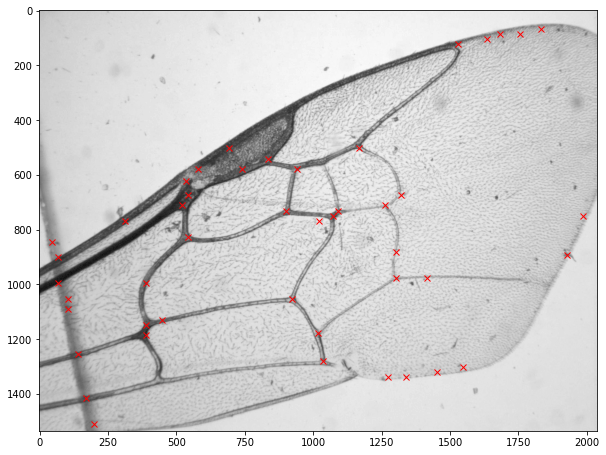

In [127]:
plt.figure(figsize=(10,15))
centroids = get_centroids(points)
for point in centroids :
        plt.plot(point[0], point[1], marker='x', color="red")
plt.imshow(im, cmap="gray")

In [24]:
def pipeline(img_path):
    im = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2LAB)
    im,_,_ = cv2.split(im)
    im_diff_gaussians = ((sk.filters.difference_of_gaussians(im, 0, 35) + 1) * 256 / 2).astype(np.uint8)
    im_open = skm.closing(im_diff_gaussians, skm.disk(3))
    im_gaussian = gaussian_filter(im_open, sigma=4)
    im_dilate = skm.closing(im_gaussian, skm.disk(5))
    im_treshold = im_dilate < 127
    im_label = sk.measure.label(im_treshold)
    tmp = np.where(np.bincount(im_label.flatten()) > 50000)[0][1:]
    im_filter = np.zeros_like(im_label).astype(bool)
    for value in tmp:
        im_filter = im_filter | (im_label == value)
    res = skm.skeletonize(gaussian_filter(skm.binary_closing(im_filter, skm.disk(4)), sigma=0.2))
    ring = my_subtract(skm.square(19), skm.square(17))
    pading = len(ring)
    points = np.zeros_like(im)
    for i in range(0, res.shape[1] - pading, pading):
        for j in range(0, res.shape[0] - pading, pading):
            window = res[j:j + pading, i:i + pading] * ring
            if window.sum() < 3:
                continue
            labels = len(np.bincount(sk.measure.label(window).flatten()))
            if labels > 3 :
                points[j + pading // 2, i + pading // 2] = 1
    return get_centroids(points)

CPU times: user 10.6 s, sys: 39.9 ms, total: 10.7 s
Wall time: 10.6 s


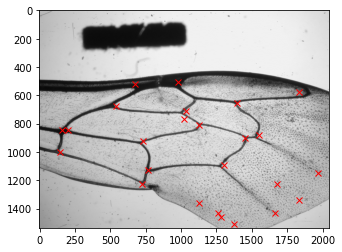

In [129]:
path = train_imgs[0]
%time centroids = pipeline(path)
for point in centroids :
        plt.plot(point[0], point[1], marker='x', color="red")
im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
plt.imshow(im)

In [ ]:
#nb = len(train_imgs)
#plt.figure(figsize=(20,15))
#for i, path in enumerate(train_imgs):
#    plt.subplot(nb//2, 2, i+1)
#    centroids = pipeline(path)
#    for point in centroids :
#        plt.plot(point[0], point[1], marker='x', color="red")
#    im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
#    plt.imshow(im)
#plt.show()
    